In [157]:
import os
import h5py
import time
import torch
import pyreadr
import numpy as np
import pandas as pd
import datetime as dt
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pandas.api.types import CategoricalDtype
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import weight_norm
from sklearn.manifold import TSNE
from livelossplot import PlotLosses
from pytorch_model_summary import summary
from tqdm.notebook import tqdm, trange

device = torch.device('cuda')

In [158]:
# from joblib import dump, load
# from sklearn import metrics
# from sklearn.model_selection import train_test_split, GroupShuffleSplit
# from sklearn.preprocessing import StandardScaler, LabelEncoder

In [159]:
class MyDataset(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, w, y, idx):
        self.w = w
        self.y = y
        self.idx = idx
            
    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
            
        idx = self.idx[idx]
        
        ww = torch.tensor(self.w[idx], dtype=torch.float, device = device)
        yy = torch.tensor(self.y[idx], dtype=torch.float, device = device)
        
        return (ww, yy)

In [160]:
class MyNet(nn.Module):

    def __init__(self, w_layers, pred_layers):

        super().__init__()
              
        # Weaher variables
        w_layers_list = nn.ModuleList()
        for i, o, k, d in w_layers:
            w_layer = nn.Sequential(
                nn.Conv1d(i, o, k),
                nn.AvgPool1d(2),
                nn.LeakyReLU(),
                nn.BatchNorm1d(o),
                nn.Dropout(d)
            )
            w_layers_list.append(w_layer)
        w_layers_list.append(nn.AdaptiveAvgPool1d(1))
        self.w_layers = nn.Sequential(*w_layers_list)

        
        # Management variables
        pred_layers_list = nn.ModuleList()
        for i, o, d in pred_layers:
            pred_layer = nn.Sequential(
                nn.Linear(i, o),
                nn.LeakyReLU(),
                nn.BatchNorm1d(o),
                nn.Dropout(d)
            )
            pred_layers_list.append(pred_layer)
        pred_layers_list.append(nn.Linear(o, 1))
        self.pred_layers = nn.Sequential(*pred_layers_list)
        
   
    def forward(self, Ws):
        
        feat = self.w_layers(Ws).view(Ws.shape[0], -1)
        pred = self.pred_layers(feat)
        return (torch.tanh(pred))


In [161]:
# Values used to scale the weather data:
ws = np.array([[[5e4,50,50,5,100.0]]])


In [162]:
ydf = pd.read_hdf('../data/PSCE_TILE.h5', key = 'SIM').set_index('SIM')
ydf['Yield'] = (ydf.TWSO/2e4)

In [163]:
wdir = '/home/rodrigo7/Apsim_test/MASAGRO/DAYMET_TILE'
pxy = np.stack(np.meshgrid(np.arange(40), np.arange(40)), -1).reshape(-1, 2)
wfiles = [f'{wdir}/DAYMET_9584_{px:02d}_{py:02d}.csv' for px, py in pxy]

sim_ww = []
sim_yy = []

wfile = wfiles[10]
for wfile in tqdm(wfiles):   
    ridx = 10 * np.arange(10) + np.random.randint(0, 10, 10)
    site = os.path.basename(wfile).replace('.csv', '')

    w = pd.read_csv(wfile, skiprows = 13)
    w.DAY = pd.to_datetime(w.DAY, format = '%Y%m%d').dt.date

    sydf = ydf.loc[site]
    sim_yy.append(sydf.Yield.values[ridx])

    wwf = []
    for crop_start_date in sydf.SIM_DATE.values[ridx]:
        cs_date = np.where(w.DAY == crop_start_date)[0][0]
        wrng = slice(cs_date-90, cs_date+210)
        ww = w.iloc[wrng,[1,2,3,4,6]].values / ws
        wwf.append(ww)

    sim_ww.append(np.concatenate(wwf))
    
sim_ww = np.stack(sim_ww)
sim_yy = np.stack(sim_yy)

In [164]:
wd = np.zeros_like(sim_ww[:,:,:,[0]])
wd = wd + np.linspace(-0.9,2.1,300)[None,None,:,None]
W = np.concatenate([sim_ww, wd], -1)
W = np.moveaxis(W, -1, -2)

In [187]:
w_std = W.std((0,1,3))
w_std[-1] = 0
w_std = torch.tensor(w_std, device = device, dtype = torch.float)[:,None]
epsilon = 0.1 * w_std

In [166]:
train_val_W = W[:,:8].reshape(-1, *W.shape[2:])
train_val_y = sim_yy[:,:8].reshape(-1, *sim_yy.shape[2:])

test_val_W = W[:,8:].reshape(-1, *W.shape[2:])
test_val_y = sim_yy[:,8:].reshape(-1, *sim_yy.shape[2:])

In [167]:
pred_idx = np.arange(len(test_val_y))

train_idx = np.arange(len(train_val_y))
val_idx = np.random.choice(train_idx, size=2800, replace=False)
train_idx = np.setdiff1d(train_idx, val_idx)
print(train_idx.shape, val_idx.shape)

(10000,) (2800,)


In [179]:
batch_size = 100

pred_dataset = MyDataset(test_val_W, test_val_y, pred_idx)
train_dataset = MyDataset(train_val_W, train_val_y, train_idx)
val_dataset = MyDataset(train_val_W, train_val_y, val_idx)


pred_loader = DataLoader(pred_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

data_inputs = iter(train_loader).next()
print(len(train_loader))


100


In [169]:
d = 0.0
w_layers =  [[6,120,3,d],[120,150,5,d],[150,200,7,d],[200,250,5,d],[250,1000,3,d]]
pred_layers = [[1000,500,d],[500,500,d], [500,250,d]]

model = MyNet(w_layers, pred_layers)
model = model.to(device)
    
model_file_name = '../data/model_cnn_grd.pth'
model.load_state_dict(torch.load(model_file_name, map_location=device))


sm = summary(model, data_inputs[0], print_summary=True,  max_depth=1)

-----------------------------------------------------------------------------
           Layer (type)         Output Shape         Param #     Tr. Param #
               Conv1d-1     [2000, 120, 298]           2,280           2,280
            AvgPool1d-2     [2000, 120, 149]               0               0
            LeakyReLU-3     [2000, 120, 149]               0               0
          BatchNorm1d-4     [2000, 120, 149]             240             240
              Dropout-5     [2000, 120, 149]               0               0
               Conv1d-6     [2000, 150, 145]          90,150          90,150
            AvgPool1d-7      [2000, 150, 72]               0               0
            LeakyReLU-8      [2000, 150, 72]               0               0
          BatchNorm1d-9      [2000, 150, 72]             300             300
             Dropout-10      [2000, 150, 72]               0               0
              Conv1d-11      [2000, 200, 66]         210,200         210,20

In [188]:
epsilon = 0.01
alpha = 0.01
attack = 'fgsm'

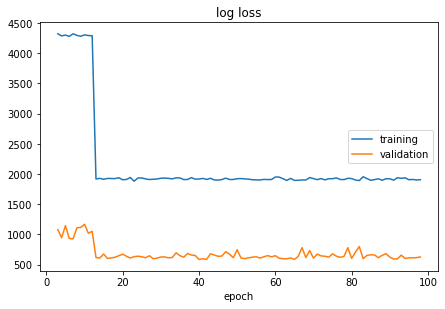

log loss:
training   (min: 1882.325, max: 4322.330, cur: 1907.221)
validation (min:  585.826, max: 1169.256, cur:  627.878)
[58:85] loss: 0.009 time:4.81


KeyboardInterrupt: 

In [189]:
for epoch in range(100):
    start_time = time.time()
    epoch_loss = []
    val_loss = []
    
    model.train()
    for i, (Ws, Ys) in enumerate(tqdm(train_loader)):
        
        if attack is not None:
            delta = torch.zeros_like(Ws).uniform_(-epsilon, epsilon)

            if attack == 'fgsm':
                delta.requires_grad = True
                output = model(Ws + delta)
                loss = criterion(output, Ys[:,None])
                loss.backward()
                grad = delta.grad.detach()
                delta.data = torch.clamp(delta + alpha * torch.sign(grad), -epsilon, epsilon)
                delta.data = torch.max(torch.min(1-Ws, delta.data), 0-Ws)
                delta = delta.detach()

            # Adding clipping to maintain [0,1] range
            adv_data = torch.clamp(Ws + delta, 0, 1)
            adv_data[:,-1] = Ws[:,-1]
            Ws = adv_data

        output = model(Ws)
        loss = criterion(output, Ys[:,None])

        # Limpa os gradientes
        optimizer.zero_grad()

        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()

        epoch_loss.append(loss.data.item())
        
    model.eval()
    for i, (Ws, Ys) in enumerate(tqdm(val_loader)):
        with torch.no_grad():
          # Obtem o output
          outputs = model(Ws)

        # Caulcula a perda pela loss function (MSE)
        loss = criterion(outputs, Ys[:,None])

        val_loss.append(loss.data.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    val_loss = np.array(val_loss).mean()
    time_taken = time.time() - start_time
    
    if val_loss < min_loss:
        # Nome da pasta com o arquivo .pth salvando os pesos do modelo treinado
        torch.save(model.state_dict(), model_file_name)
        bad_epochs = 0
        min_loss = val_loss
    else:
        bad_epochs += 1
    
    if bad_epochs > 500:
        break

    liveloss.update({
        'log loss': np.sqrt(epoch_loss) * 2e4,
        'val_log loss': np.sqrt(val_loss) * 2e4
    })
    liveloss.draw() #Apresenta o gráfico log loss
    print('[%d:%d] loss: %.3f time:%.2f' % (bad_epochs, epoch, epoch_loss, time_taken))


In [156]:
model.eval()
criterion = nn.MSELoss()

adv_w = []
adv_o = []
adv_y = []
for i, (data, target) in enumerate(tqdm(train_dataset)):

    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True

    # Forward pass the data through the model
    output = model(data[None])[0]

    # Calculate the loss
    loss = criterion(output, target[None])

    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = data.grad.data     

    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    adv_data = data + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    adv_data = torch.clamp(adv_data, 0, 1)
    adv_data[:,-1] = data[:,-1]

    # Return the perturbed image
    adv_w.append(adv_data.data.cpu().numpy())
    adv_o.append(output.data.cpu().numpy())
    adv_y.append(target.data.cpu().numpy())

adv_w = np.stack(adv_w)
adv_o = np.stack(adv_o)
adv_y = np.stack(adv_y)

In [ ]:
# Repeat 10 times:
#     create adv using a sample of 10 %
#     append to train data
#     train model 100 epochs
    

In [154]:
min_loss = 10
bad_epochs = 0
liveloss = PlotLosses()

In [99]:
# batch_size = 2000

adv_idx = np.arange(len(adv_y))
adv_dataset = MyDataset(adv_w, adv_y, adv_idx)
adv_loader = DataLoader(adv_dataset, batch_size=batch_size, shuffle=True)

data_inputs = iter(adv_loader).next()
# print(len(train_loader))


IndexError: tuple index out of range

In [79]:
adv_w = np.stack([w for w, o, y in adv_dataset])
adv_o = np.stack([o for w, o, y in adv_dataset])
adv_y = np.stack([y for w, o, y in adv_dataset])

In [153]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

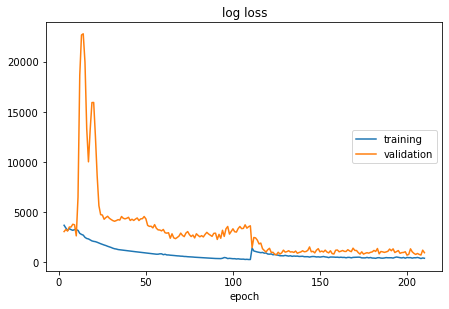

log loss:
training   (min:  294.618, max: 4434.579, cur:  419.363)
validation (min:  728.925, max: 22780.578, cur:  975.090)
[10:99] loss: 0.000 time:0.70


In [91]:
for epoch in range(100):
    start_time = time.time()
    epoch_loss = []
    val_loss = []
    
    model.train()
    for i, (Ws, Ys) in enumerate(tqdm(train_loader)):
        
        # Limpa os gradientes
        optimizer.zero_grad()
    
        # Obtem o output
        outputs = model(Ws)

        # Caulcula a perda pela loss function
        loss = criterion(outputs, Ys[:,None])
        
        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()
        epoch_loss.append(loss.data.item())
        
    
    # Limpa os gradientes
    optimizer.zero_grad()

    # Obtem o output
    outputs = model(torch.tensor(adv_w, device = device, dtype = torch.float))

    # Caulcula a perda pela loss function
    loss = criterion(outputs, torch.tensor(adv_y[:,None], device = device, dtype = torch.float))
        
    # Obtem os gradientes
    loss.backward()

    # Atualiza os parâmetros
    optimizer.step()
    epoch_loss.append(loss.data.item())

        
    model.eval()
    for i, (Ws, Ys) in enumerate(tqdm(val_loader)):
        with torch.no_grad():
          # Obtem o output
          outputs = model(Ws)

        # Caulcula a perda pela loss function (MSE)
        loss = criterion(outputs, Ys[:,None])

        val_loss.append(loss.data.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    val_loss = np.array(val_loss).mean()
    time_taken = time.time() - start_time
    
    if val_loss < min_loss:
        # Nome da pasta com o arquivo .pth salvando os pesos do modelo treinado
        torch.save(model.state_dict(), model_file_name)
        bad_epochs = 0
        min_loss = val_loss
    else:
        bad_epochs += 1
    
    if bad_epochs > 500:
        break

    liveloss.update({
        'log loss': np.sqrt(epoch_loss) * 2e4,
        'val_log loss': np.sqrt(val_loss) * 2e4
    })
    liveloss.draw() #Apresenta o gráfico log loss
    print('[%d:%d] loss: %.3f time:%.2f' % (bad_epochs, epoch, epoch_loss, time_taken))


In [94]:
# Realiza a predição dos dados a partir do modelo treinado - Dados de validação
model.eval()
adv_ypred = []
for (data, obs, target) in tqdm(adv_dataset):
    with torch.no_grad():
        pred = model(torch.tensor(data[None], device = device))
    adv_ypred.append(pred[0].cpu().data.numpy())
adv_ypred = np.concatenate(adv_ypred)



0.9801


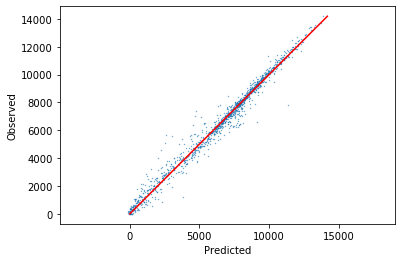

In [95]:
x = adv_o.reshape(-1) * 2e4
y = adv_y.reshape(-1) * 2e4

ax = plt.axes()
ax.set_aspect('equal', 'datalim')

plt.scatter(x, y, 0.1, alpha=0.9)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k-', color = 'r')
print(np.round(np.corrcoef(x, y, rowvar=False)[1,0],3)**2)
plt.show()

0.762129


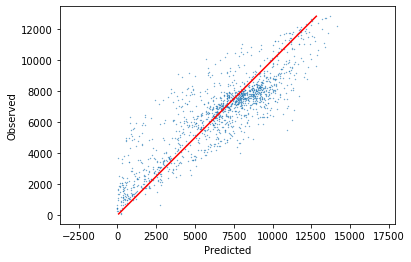

In [96]:
x = adv_y.reshape(-1) * 2e4
y = adv_ypred.reshape(-1) * 2e4

ax = plt.axes()
ax.set_aspect('equal', 'datalim')

plt.scatter(x, y, 0.1, alpha=0.9)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k-', color = 'r')
print(np.round(np.corrcoef(x, y, rowvar=False)[1,0],3)**2)
plt.show()

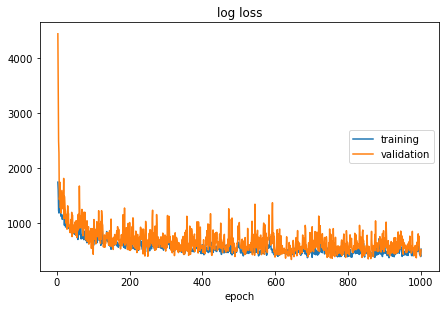

log loss:
training   (min:  371.020, max: 2100.001, cur:  527.382)
validation (min:  338.802, max: 4441.782, cur:  518.801)
[356:999] loss: 0.001 time:0.43


In [83]:
for epoch in range(1000):
    start_time = time.time()
    epoch_loss = []
    val_loss = []
    
    model.train()
    for i, (Ws, Ys) in enumerate(tqdm(train_loader)):
        
        # Limpa os gradientes
        optimizer.zero_grad()
    
        # Obtem o output
        outputs = model(Ws)

        # Caulcula a perda pela loss function
        loss = criterion(outputs, Ys[:,None])
        
        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()
        epoch_loss.append(loss.data.item())
        
    model.eval()
    for i, (Ws, Ys) in enumerate(tqdm(val_loader)):
        with torch.no_grad():
          # Obtem o output
          outputs = model(Ws)

        # Caulcula a perda pela loss function (MSE)
        loss = criterion(outputs, Ys[:,None])

        val_loss.append(loss.data.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    val_loss = np.array(val_loss).mean()
    time_taken = time.time() - start_time
    
    if val_loss < min_loss:
        # Nome da pasta com o arquivo .pth salvando os pesos do modelo treinado
        torch.save(model.state_dict(), model_file_name)
        bad_epochs = 0
        min_loss = val_loss
    else:
        bad_epochs += 1
    
    if bad_epochs > 500:
        break

    liveloss.update({
        'log loss': np.sqrt(epoch_loss) * 2e4,
        'val_log loss': np.sqrt(val_loss) * 2e4
    })
    liveloss.draw() #Apresenta o gráfico log loss
    print('[%d:%d] loss: %.3f time:%.2f' % (bad_epochs, epoch, epoch_loss, time_taken))


In [84]:
model.load_state_dict(torch.load(model_file_name, map_location=device))
print('Model OK')

Model OK


In [85]:
# Inicia o tempo para contagem
start_time = time.time()

# Realiza a predição dos dados a partir do modelo treinado - Dados de validação
model.eval()
obs = []
preds = []
for k in trange(100):
    for i, (Ws, Ys) in enumerate((val_loader)):
        obs.append(Ys.cpu().data.numpy())
        with torch.no_grad():
            pred = model(Ws)
        preds.append(pred.cpu().data.numpy())
obs = np.concatenate(obs)
preds = np.concatenate(preds)

# Faz a diferença para calcular o tempo           
time_taken = time.time() - start_time
# Apresenta o valor do tempo
print('time:%.2f' % (time_taken))


time:3.00


0.9801


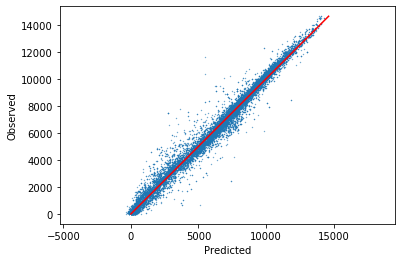

In [86]:
x = preds.reshape(-1) * 2e4
y = obs.reshape(-1) * 2e4

ax = plt.axes()
ax.set_aspect('equal', 'datalim')

plt.scatter(x, y, 0.1, alpha=0.9)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k-', color = 'r')
print(np.round(np.corrcoef(x, y, rowvar=False)[1,0],3)**2)
plt.show()

In [87]:
idx_max = sim_yy.mean(1).argmax()
idx_min = sim_yy.mean(1).argmin()

In [88]:
idx_min

1182

In [89]:
ymax = pred_dataset[idx_max][1][None].cpu().data.numpy()
ymin = pred_dataset[idx_min][1][None].cpu().data.numpy()
wmax = pred_dataset[idx_max][0][None]
wmin = pred_dataset[idx_min][0][None]
wmaxo = wmax.clone()
wmino = wmin.clone()

wmax.requires_grad = True
wmin.requires_grad = True

In [90]:
ymax_pred = model(wmax).cpu().data.numpy()
ymin_pred = model(wmin).cpu().data.numpy()

In [91]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam([wmax], lr=0.1)

In [92]:
yield_loss = PlotLosses(skip_first = 0)

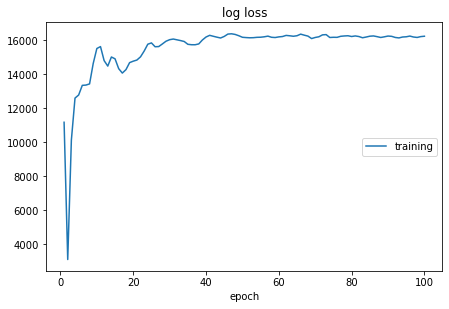

log loss:
training   (min: 3076.634, max: 16360.878, cur: 16216.838)


In [93]:
eps = 0.01
model.eval()
for i in trange(100):

    # Limpa os gradientes
    optimizer.zero_grad()

    # Obtem o output
    outputs = model(wmax)

    # Caulcula a perda pela loss function
    loss = -outputs.mean()
    
    # Use an l2 penalty:
    loss += criterion(wmaxo, wmax)/eps
        
    # Obtem os gradientes
    loss.backward()

    # Atualiza os parâmetros
    optimizer.step()
    
    # Clip to the valid range of values:
    wmax.data = torch.clamp(wmax.data, 0, 1)
    wmax.data[:,-1] = wmaxo[:,-1]

    yield_loss.update({
        'log loss': 2e4 * outputs.mean().item()
    })
yield_loss.draw()

Text(0, 0.5, 'Yield')

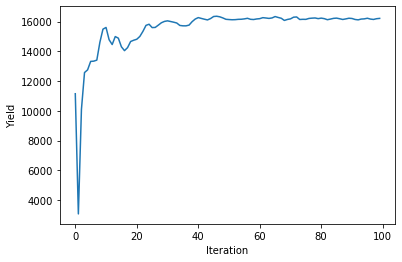

In [94]:
plt.plot(pd.DataFrame(yield_loss.logs).values[:,0])
plt.xlabel('Iteration')
plt.ylabel('Yield')


In [95]:
pred = outputs.cpu().data.numpy()

In [96]:
wmax_np = wmax.data.cpu().numpy()
wmaxo_np = wmaxo.data.cpu().numpy()


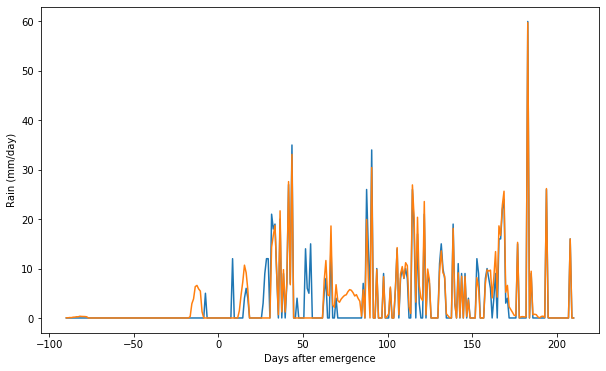

In [97]:
plt.figure(figsize=(10,6))
xx = np.linspace(-90, 210, 300)
plt.plot(xx, 100 * np.stack([wmaxo_np[0,-2], wmax_np[0,-2]], 1))
plt.xlabel('Days after emergence')
plt.ylabel('Rain (mm/day)')
plt.show()

In [98]:
# Save weather data in the format needed
# Run the WOFOST model and compare the results.

In [99]:
# Compare adversarial trained vs plain trained model generalization
# Using FGSM

# Certified robustness wihtin confidence interval